In [2]:
!pip install sklearn

You should consider upgrading via the '/home/barteus/Work/test/pytorch-mlflow/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import mlflow

In [ ]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

In [5]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [6]:
model = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
model

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [7]:
EPOCHS = 100
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test = Variable(torch.from_numpy(X_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()

loss_list = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

mlflow.start_run()
for epoch in range(1, EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()

    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

mlflow.pytorch.log_model(model, "pymodel", registered_model_name="iris-model")
mlflow.end_run()

100%|██████████| 100/100 [00:00<00:00, 1375.66it/s]


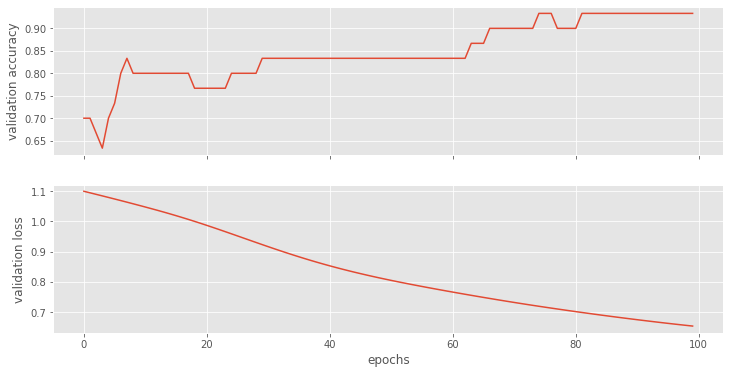

In [8]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

In [10]:
X_train[0]

tensor([ 0.4322, -0.5924,  0.5922,  0.7907])